# Phase 2 - Computer Vision Project
### Table of Contents
1) [Image Processing](#ip)<br>
2) [Feature Extraction](#FE)<br>
3) [Tesing the Functions](#TF)<br>
4) [Unify the Functions](#UF)<br>
5) [Heat Mapping](#HM)<br>
6) [Video Demo](#VD)

In [1]:
import os
import time
import glob
import itertools as it
import numpy as np
import cv2
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from lane_detection import Lane_detection
%matplotlib inline

## Image Processing <a class="anchor" id="ip"></a>

In [2]:
base_dir = 'vehicles/'
image_types = os.listdir(base_dir)
cars = []
for image_type in image_types:
    cars.extend(glob.glob(base_dir + image_type + '/*'))
    
base_dir = 'non-vehicles/'
image_types = os.listdir(base_dir)
not_cars = []
for image_type in image_types:
    not_cars.extend(glob.glob(base_dir + image_type + '/*'))
    
print('Number of vehicles images:', len(cars))
print('Number of non-vehicles images:', len(not_cars))

Number of vehicles images: 8792
Number of non-vehicles images: 8968


Binning is a data science technique where the data of neighboring pixels are combined together to form a super-pixel.  In this project, the code will bin a large number of pixels together to be able to differentiate objects in the image.

In [3]:
def convert_color(img, conv='YCrCb'):
    if conv != 'RGB':
        if conv == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif conv == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif conv == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif conv == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif conv == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        return img

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

Histogram of Oriented Gradients, also known as HOG, is a feature descriptor like the Canny Edge Detector. It is used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in the localized portion of an image. <br><br>
The HOG descriptor focuses on the structure or the shape of an object. It is better than any edge descriptor as it uses magnitude as well as angle of the gradient to compute the features. For the regions of the image it generates histograms using the magnitude and orientations of the gradient


In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

## Feature Extraction <a class="anchor" id="FE"></a>

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32,32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, conv=color_space)
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            file_features.append(spatial_features)
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            file_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        #9) Return concatenated array of features
    return features

In [6]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, conv=color_space)     
    #3) Compute spatial features if flag is set
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
    if vis:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

Train previously classified image of car and not car 

In [7]:
color_space = 'HLS' 
orient = 32
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" 
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
#Extracting features of the cars from cars list
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

#Extracting features of the other objects from not_cars list
not_car_features = extract_features(not_cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, not_car_features)).astype(np.float64) 
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.15, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 6624
32.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9955
My SVC predicts:  [1. 1. 0. 1. 0. 0. 1. 1. 1. 1.]
For these 10 labels:  [1. 1. 0. 1. 0. 0. 1. 1. 1. 1.]
0.00306 Seconds to predict 10 labels with SVC


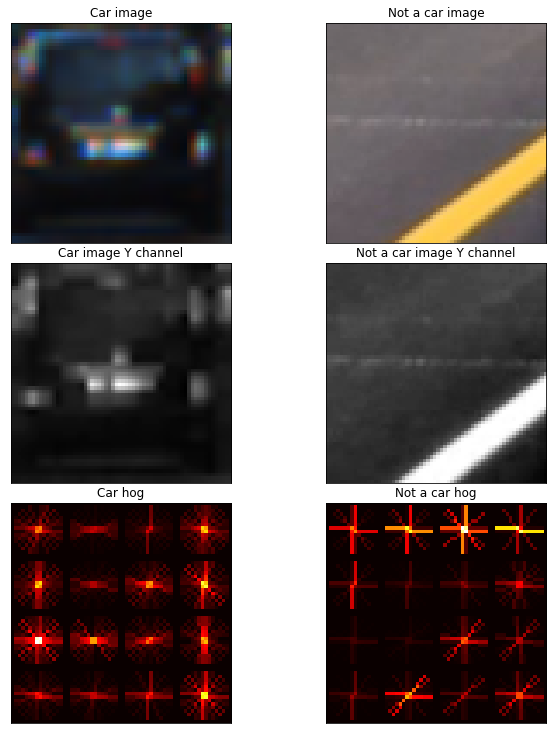

In [8]:
car_ind = np.random.randint(0, len(cars))
not_car_ind = np.random.randint(0, len(not_cars))
car_image = mpimg.imread(cars[car_ind])
not_car_image = mpimg.imread(not_cars[not_car_ind])

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=0,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
not_car_features, not_car_hog_image = single_img_features(not_car_image, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=0,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.imshow(car_image)
plt.title('Car image')
plt.xticks([])
plt.yticks([])
plt.subplot(3,2,2)
plt.imshow(not_car_image)
plt.title('Not a car image')
plt.xticks([])
plt.yticks([])
plt.subplot(3,2,3)
plt.imshow(car_image[:,:,0], cmap='gray')
plt.title('Car image Y channel')
plt.xticks([])
plt.yticks([])
plt.subplot(3,2,4)
plt.imshow(not_car_image[:,:,0], cmap='gray')
plt.title('Not a car image Y channel')
plt.xticks([])
plt.yticks([])
plt.subplot(3,2,5)
plt.imshow(car_hog_image, cmap='hot')
plt.title('Car hog')
plt.xticks([])
plt.yticks([])
plt.subplot(3,2,6)
plt.imshow(not_car_hog_image, cmap='hot')
plt.title('Not a car hog')
plt.xticks([])
plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    window_list = []
    if x_start_stop[0]==None:
        x_start_stop[0] = 0
    if x_start_stop[1]==None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0]==None:
        y_start_stop[0] = 0
    if y_start_stop[1]==None:
        y_start_stop[1] = img.shape[0]
    xs = range(x_start_stop[0], x_start_stop[1]-xy_window[0]+1, int(xy_window[0]*xy_overlap[0]))
    ys = range(y_start_stop[0], y_start_stop[1]-xy_window[1]+1, int(xy_window[1]*xy_overlap[1]))
    window_list = [((x, y),(x+xy_window[0], y+xy_window[1])) for x, y in it.product(xs, ys)]
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
 
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='HLS', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows  

## Testing the Functions <a class="anchor" id="TF"></a>

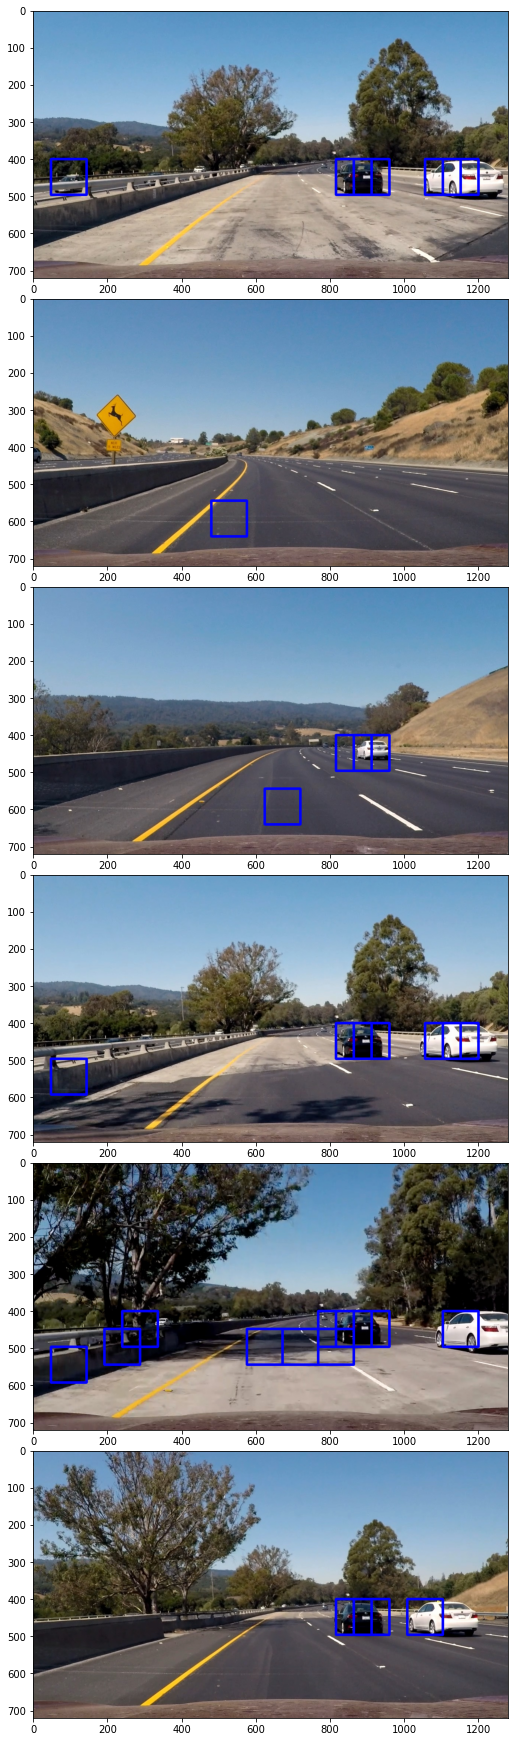

In [10]:
#get all test images
path = 'test_images/*'
example_images = glob.glob(path)

images = []
titles = []
y_start_stop = [400, 656]
overlap = 0.5

row = len(example_images)
plt.figure(figsize=(10,4*row))
for i, example in enumerate(example_images):
    t1 = time.time()
    img = mpimg.imread(example)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(96, 96), xy_overlap=(overlap, overlap))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    plt.subplot(row, 1, i+1)
    plt.imshow(window_img)
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

## Unify the Functions <a class="anchor" id="UF"></a>

In [11]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space):
    img_boxes = []
    draw_img = np.copy(img)
    heat_map = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,xstart:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    imshape = ctrans_tosearch.shape
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            #count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))      
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left+xstart, ytop_draw+ystart), (xbox_left+win_draw+xstart, ytop_draw+ystart+win_draw)))
                heat_map[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left+xstart:xbox_left+win_draw+xstart] += 1
            count += 1
    return draw_img, heat_map, img_boxes, count  

## Heat Mapping <a class="anchor" id="HM"></a>

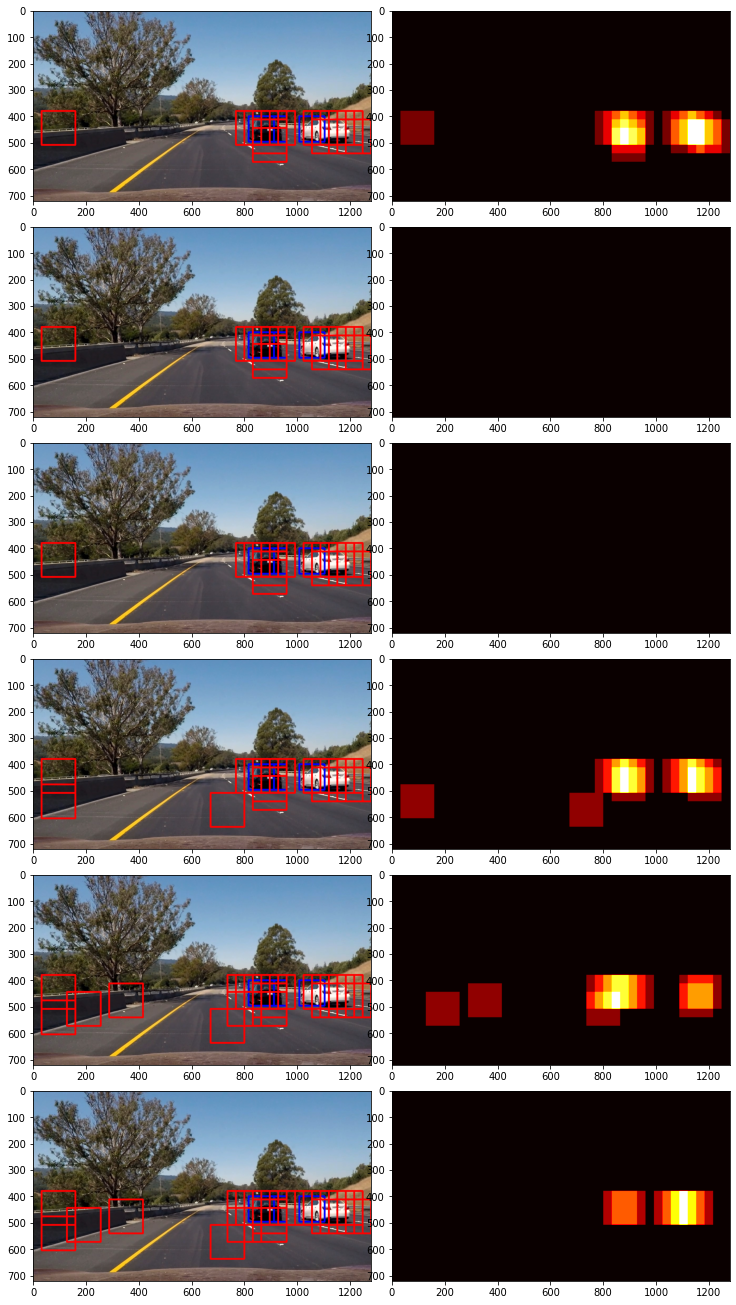

In [12]:
ystart = 380
ystop = 720
xstart = 0
row = len(example_images)
plt.figure(figsize=(10,3*row))
for i, example in enumerate(example_images):
    t1 = time.time()
    img = mpimg.imread(example)
   
    scale = 2
    out_img, heat_map, img_boxes2, count2 = find_cars(img, ystart, ystop, xstart, scale, svc, X_scaler, orient,
                                                       pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space=color_space)

    window_img = draw_boxes(window_img, img_boxes2, color=(255,0,0), thick=6)
    
    plt.subplot(row, 2, i*2+1)
    plt.imshow(window_img)
    plt.subplot(row, 2, i*2+2)
    
    #using hot colour map to increase the accuracy of vehicle detection
    plt.imshow(heat_map, cmap='hot')
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show() 

In [13]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return np.clip(heatmap, 0, 255)

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

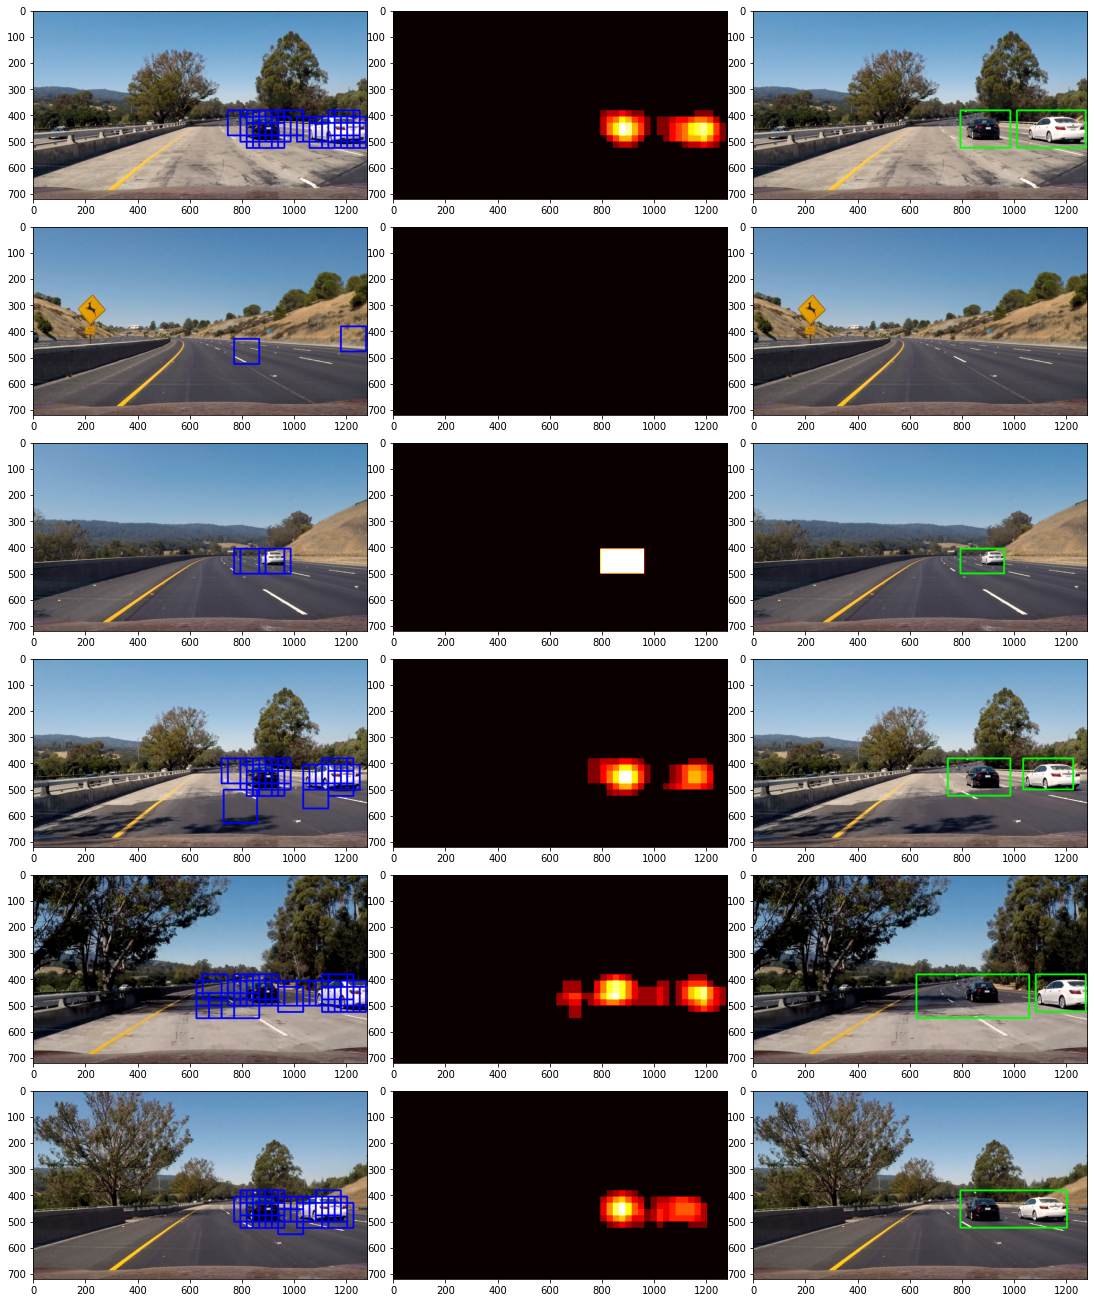

In [14]:
xstart = 600
row = len(example_images)
plt.figure(figsize=(15,3*row))
for i, example in enumerate(example_images):
    t1 = time.time()
    img = mpimg.imread(example)
    scale = 1.5
    _, heat_map1, windows1, count1 = find_cars(img, ystart, 600, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space=color_space)
    scale = 2
    _, heat_map2, windows2, count2 = find_cars(img, 500, ystop, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space=color_space)
    heat_map = heat_map1+heat_map2   
    window_img = draw_boxes(img, windows1+windows2, color=(0,0,255), thick=6)
    apply_threshold(heat_map, 1)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    plt.subplot(row, 3, i*3+1)
    plt.imshow(window_img)
    plt.subplot(row, 3, i*3+2)
    plt.imshow(heat_map, cmap='hot')
    plt.subplot(row, 3, i*3+3)
    plt.imshow(draw_img)
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()       

In [15]:
class Heat_map():
    def __init__(self):
        self.heat_maps = []
        self.heat_map = None
        self.n = 10
    
    def add(self, heat_map):
        if len(self.heat_maps) == self.n:
            self.heat_maps = self.heat_maps[1:]
        self.heat_maps.append(apply_threshold(heat_map, 1))
        self.heat_map = sum(self.heat_maps)
        return self.heat_map


In [16]:
ld = Lane_detection()
heat_map = Heat_map()
def pipeline(img):
    scale = 1.5
    _, heat_map2, _, _ = find_cars(img, ystart, 600, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space=color_space)
    scale = 2
    _, heat_map1, _, _ = find_cars(img, 500, ystop, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space=color_space)
    labels = label(heat_map.add(heat_map1+heat_map2))
    return draw_labeled_bboxes(img, labels)

## Video Demo <a class="anchor" id="VD"></a>

In [17]:
project_output = 'project_phase2.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,2)
project_clip = clip1.fl_image(pipeline)
%time project_clip.write_videofile(project_output, audio=False)

Moviepy - Building video project_phase2.mp4.
Moviepy - Writing video project_phase2.mp4



Moviepy - Done !
Moviepy - video ready project_phase2.mp4
Wall time: 13min 31s


In [21]:
def debugging_mode(debug = False):
    if(debug):
        show_image(car_image, "Car Image")
        show_image(not_car_image, "Not Car Image")
        show_image(car_image[:,:,0], cmap='gray')
        show_image(not_car_image[:,:,0], cmap='gray')
        show_image(car_image[:,:,0], cmap='hot')
        show_image(not_car_image[:,:,0], cmap='hot')
        show_image('pipeline.png', "Pipeline")